In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
import torch.nn.functional as F

# Replace with the URL you copied
url = 'https://raw.githubusercontent.com/jvilchesf/Learning/main/Andrej_karpathy_videos/Makemore/names.txt'

response = requests.get(url)
words = response.text.splitlines()

In [3]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
len(words)


32033

In [5]:
#Creating dictionaries
alphabet = sorted(list(set(''.join(words))))
itos = {idx + 1: ch for idx, ch in enumerate(alphabet)} 
itos[0] = '.'
stoi = {s : i  for i, s in itos.items()} 


In [6]:
#Creating the dataset

block_size = 3
vocab_size = len(itos)
def create_dataset(words): 
    X = []
    Y = []
    for word in words:
        context = block_size * [0]

        for i in word + '.':
            idx = stoi[i]
            Y.append(idx)
            X.append(context)
            #print(f"{context} ---> {i}")
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = create_dataset(words[:n1])
Xdev, Ydev = create_dataset(words[n1:n2])
Xte, Yte = create_dataset(words[n2:])

print (Xtr.shape, Ytr.shape)    
print (Xdev.shape, Ydev.shape)
print (Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [192]:
#Declare parameters w1, w2, b1, b2
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),          generator=g)
# Input layer
W1 = torch.randn((block_size * n_embd, n_hidden),       generator=g) / (5/3) / (block_size * n_embd) ** 0.5 
b1 = torch.randn(n_hidden,                              generator=g) * 0.01
#Output layer
W2 = torch.randn(n_hidden, vocab_size,                  generator=g)  * 0.1 #it is multiply by 0.1 to get smaller logits and smaller loss
b2 = torch.randn(vocab_size,                            generator=g)  * 0 # it is declare as 0 for the model initialization


#Batch normalization parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2,bngain, bnbias]
print(f"Number of parameters =  {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad = True


Number of parameters =  12297


In [193]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [194]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.7900, grad_fn=<NegBackward0>)

In [195]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n

dprobs = (1 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims = True)
dcounts = counts_sum_inv * dprobs # [32 x 1] x [32 x 27] = [32 x 27]
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv  # d/dx x**-1 --->  -1 / x**2
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits =  dnorm_logits.clone()
dlogit_maxes = -dnorm_logits.sum(1, keepdims = True)
dlogits += F.one_hot((logits.max(1).indices), vocab_size) * dlogit_maxes
dh = dlogits @ W2.t()
dW2 = h.t() @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdims = True)
dbnraw = bngain * dhpreact  
dbnbias = dhpreact.sum(0, keepdims = True)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims = True)
dbndiff = bnvar_inv * dbnraw
dbnvar =  (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = -dbndiff.sum(0)
dhprebn += 1.0 /n * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.t()
dW1 = embcat.t() @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)

# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
#cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [196]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.790031909942627 diff: 2.384185791015625e-07


In [198]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1 
dlogits /= n
cmp('logits', dlogits, logits)

emb             | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09


In [208]:
F.softmax(logits, 1)[0]

tensor([0.0124, 0.1804, 0.0151, 0.0345, 0.0480, 0.0186, 0.0121, 0.0137, 0.0294,
        0.0264, 0.0725, 0.0085, 0.0220, 0.0063, 0.0194, 0.0199, 0.0345, 0.0056,
        0.0025, 0.0191, 0.1214, 0.0557, 0.0708, 0.0143, 0.0041, 0.0666, 0.0663],
       grad_fn=<SelectBackward0>)

In [216]:
dlogits[0].sum()

tensor(-3.0268e-09, grad_fn=<SumBackward0>)

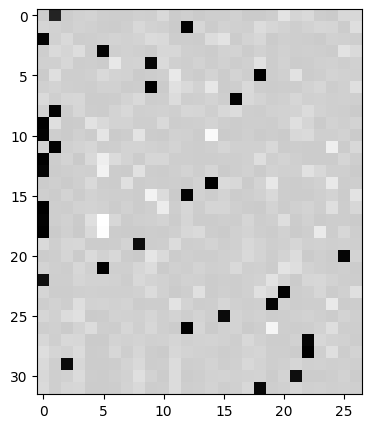

In [207]:
plt.figure(figsize = (20, 5))
plt.imshow(dlogits.detach(), cmap = 'grey')